# 调整图片为星际2可用贴图格式

1. 调整alpha透明度
2. 调整宽高比为正方形（alpha填充）
3. 针对button，调整到统一的大小（76*76）
4. 转换为`*.dds`

### 安装dds转换依赖

Wand库：https://imagemagick.org/script/download.php#windows

In [4]:
%pip install Wand

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import io

from PIL import Image as PilImage
from wand.image import Image as WandImage

# 0.DDS处理为图片

In [7]:
from wand.exceptions import WandError
import os

def convert_dds_to_png_wand(dds_path, png_path):
    """
    使用 Wand (ImageMagick) 将 DDS 文件转换为 PNG 文件。

    :param dds_path: 输入的 DDS 文件路径。
    :param png_path: 输出的 PNG 文件路径。
    """
    if not os.path.exists(dds_path):
        print(f"错误: 输入文件 '{dds_path}' 不存在。")
        return

    try:
        # 使用 'with' 语句可以确保资源被正确关闭
        with WandImage(filename=dds_path) as img:
            # 将图像格式转换为 'png'，这会处理好内部的颜色和通道
            img.format = 'png'
            # 保存转换后的文件
            img.save(filename=png_path)
        print(f"成功将 '{dds_path}' 转换为 '{png_path}'")
    except WandError as e:
        print(f"转换失败: {e}")
        print("请检查:")
        print("1. ImageMagick 是否已正确安装并添加到系统 PATH。")
        print("2. 您的 ImageMagick 版本是否支持该 DDS 文件的压缩格式。")
    except Exception as e:
        print(f"发生未知错误: {e}")

## 1. 读取文件并转换宽高比

In [9]:
def resize_by_width(image_path, new_width):
    """
    按固定宽度调整图像大小，同时保持宽高比。

    :param image_path: 输入图片路径
    :param new_width: 新的宽度
    :param output_path: 输出图片路径
    """
    img = PilImage.open(image_path)
    # 计算新的高度
    width_percent = (new_width / float(img.size[0]))
    new_height = int((float(img.size[1]) * float(width_percent)))
    # 调整图像大小
    resized_img = img.resize((new_width, new_height), PilImage.Resampling.LANCZOS)
    return resized_img

In [6]:
resized_img = resize_by_width('../data/png/多彩核弹/btn-ability-terran-armnuke-rainbow.png',new_width=76)

In [10]:
base_name = '../'

## 2.转换并输出到目录

In [12]:
def convert_png_to_dds(pil_image, dds_path, compression='dxt5'):
    """
    接收一个 Pillow 图像对象，进行处理（可选），然后转换为 DDS。

    :param pil_image: 输入的 Pillow Image 对象。
    :param dds_path: 输出的 DDS 文件路径。
    :param compression: DDS 压缩格式。
    """
    try:
        # --- 核心步骤：将 Pillow 对象转换为 Wand 对象 ---
        image_binary = io.BytesIO()
        pil_image.save(image_binary, format='png')
        image_binary.seek(0)
        
        with WandImage(blob=image_binary.read()) as img:
            # 现在 img 是一个 wand 对象，可以进行 wand 的操作
            img.options['dds:compression'] = compression
            img.options['dds:mipmaps'] = '7'
            img.save(filename=dds_path)
            
        print(f"成功将处理后的图像转换为 '{dds_path}' (压缩格式: {compression})")

    except Exception as e:
        print(f"转换失败: {e}")

In [13]:
def convert_png_to_dds(png_image_obj, save_fname, dds_save_folder, compression='dxt5',generate_mipmaps=True):
    """
    使用 Wand (ImageMagick) 将 PNG 转换为 DDS。

    :param png_path: 输入的 PNG 文件路径。
    :param dds_path: 输出的 DDS 文件路径。
    :param compression: DDS 压缩格式 (例如 'dxt1', 'dxt5', 'none')。
    """
    try:
        # --- 核心步骤：将 Pillow 对象转换为 Wand 对象 ---
        image_binary = io.BytesIO()
        png_image_obj.save(image_binary, format='png')
        image_binary.seek(0)
        dds_path = os.path.join(dds_save_folder,save_fname.lower().replace('.png','.dds'))
        with WandImage(blob=image_binary.read()) as original_img:
            with original_img.clone() as color_fixed_img:
                # 步骤1: 修复颜色渗透
                # 'remove' 操作会用边缘颜色填充透明区域，然后使图像变为不透明。
                # 这是我们修复 RGB 通道的关键步骤。
                color_fixed_img.alpha_channel = 'remove'

                # 步骤2: 恢复原始 Alpha 通道
                # 将 original_img 的 Alpha 通道复制回 color_fixed_img。
                # 这保证了 Alpha 通道 100% 不变，实现了您的“保留alpha通道”的要求。
                color_fixed_img.composite(original_img, operator='copy_alpha')
                
                # 步骤3: 设置 DDS 选项并保存最终结果
                color_fixed_img.options['dds:compression'] = compression
                color_fixed_img.options['dds:mipmaps'] = '7' # 生成 mipmaps
                color_fixed_img.save(filename=dds_path)
            
        print(f"成功将 '{save_fname}' 转换保存到 '{dds_path}' (压缩格式: {compression})")
    except Exception as e:
        print(f"转换失败: {e}")

## 3.批量转换

In [23]:
png_folder = '../data/原始png/地堡/'
for fname in os.listdir(png_folder):
    resized_img = resize_by_width(os.path.join(png_folder, fname),76)
    convert_png_to_dds(png_image_obj=resized_img,
                       save_fname=fname,
                       dds_save_folder='../data/assets/',
                       compression='dxt3',generate_mipmaps=True)

成功将 'btn-unit-terran-hivemindemulator-bunker.png' 转换保存到 '../data/assets/btn-unit-terran-hivemindemulator-bunker.dds' (压缩格式: dxt3)
成功将 'btn-unit-terran-perdition-bunker.png' 转换保存到 '../data/assets/btn-unit-terran-perdition-bunker.dds' (压缩格式: dxt3)
成功将 'btn-unit-terran-psidisruptor-bunker.png' 转换保存到 '../data/assets/btn-unit-terran-psidisruptor-bunker.dds' (压缩格式: dxt3)


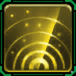

In [19]:
resized_img